In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.stat import Correlation
from pyspark.ml import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

In [5]:
import builtins

In [6]:
# ============================================================================
# 1. SPARK SESSION SETUP AND DATA LOADING
# ============================================================================
print("\n1. Setting up Spark Session for Advanced Feature Engineering...")

spark = SparkSession.builder \
    .appName("FraudDetection_FeatureEngineering") \
    .config("spark.driver.memory", "6g") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.sql.adaptive.skewJoin.enabled", "true") \
    .getOrCreate()

print(f"Spark Version: {spark.version}")
print(f"Spark UI: {spark.sparkContext.uiWebUrl}")


1. Setting up Spark Session for Advanced Feature Engineering...


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/07/30 08:16:19 WARN Utils: Your hostname, Howards-MacBook-Air.local, resolves to a loopback address: 127.0.0.1; using 10.74.245.116 instead (on interface en0)
25/07/30 08:16:19 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/30 08:16:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Version: 4.0.0
Spark UI: http://10.74.245.116:4040


In [7]:
df = spark.read.csv("creditcard_2023.csv", header=True, inferSchema=True)
df = df.cache()
# 什麼是cache? 可以將數據暫存在記憶體中，避免重複從磁碟讀取，以加速後續操作
df.createOrReplaceTempView("transactions")

25/07/30 08:16:28 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [8]:
# ============================================================================
# 2. BASIC FEATURE STATISTICS WITH SPARK SQL
# ============================================================================
print("\n2. Computing Advanced Statistics with Spark SQL...")

stats_sql = """
SELECT 
    Class,
    COUNT(*) as transaction_count,
    ROUND(AVG(Amount), 2) as avg_amount,
    ROUND(STDDEV(Amount), 2) as stddev_amount,
    ROUND(MIN(Amount), 2) as min_amount,
    ROUND(MAX(Amount), 2) as max_amount,
    ROUND(PERCENTILE_APPROX(Amount, 0.25), 2) as q25_amount,
    ROUND(PERCENTILE_APPROX(Amount, 0.5), 2) as median_amount,
    ROUND(PERCENTILE_APPROX(Amount, 0.75), 2) as q75_amount,
    ROUND(PERCENTILE_APPROX(Amount, 0.95), 2) as p95_amount
FROM transactions 
GROUP BY Class
ORDER BY Class
"""

stats_result = spark.sql(stats_sql)
print("Amount Statistics by Class: ")
stats_result.show()


2. Computing Advanced Statistics with Spark SQL...
Amount Statistics by Class: 


+-----+-----------------+----------+-------------+----------+----------+----------+-------------+----------+----------+
|Class|transaction_count|avg_amount|stddev_amount|min_amount|max_amount|q25_amount|median_amount|q75_amount|p95_amount|
+-----+-----------------+----------+-------------+----------+----------+----------+-------------+----------+----------+
|    0|           284315|  12026.31|       6929.5|     50.12|  24039.93|   6034.51|     11996.35|  18039.55|  22842.05|
|    1|           284315|   12057.6|      6909.75|     50.01|  24039.93|   6074.14|     12062.01|  18031.51|  22828.18|
+-----+-----------------+----------+-------------+----------+----------+----------+-------------+----------+----------+



In [9]:
# ============================================================================
# 3. ADVANCED FEATURE ENGINEERING
# ============================================================================
print("\n3. Creating Advanced Features with Spark...")

# 3.1 Amount Based Features
# log1p = log(1+x)，可以用來解決金融數據中為0的數據，減少極端值的影響

df_features = df.withColumn("amount_log", log1p(col("Amount"))) \
                .withColumn("amount_sqrt", sqrt(col("Amount"))) \
                .withColumn("amount_squared", pow(col("Amount"), 2)) 
# if using pandas
# df['amount_log'] = np.log1p(df['Amount'])
# df['amount_sqrt'] = np.sqrt(df['Amount'])
# df['amount_squared'] = df['Amount']**2

# 3.2 Statistical features from V columns
v_columns = [f"V{i}" for i in range(1, 29)]

# Calculate sum and mean of V features
v_sum_expr = col("V1")
for v_col in v_columns[1:]:  
    v_sum_expr = v_sum_expr + col(v_col)

df_features = df_features.withColumn("v_sum", v_sum_expr) \
                        .withColumn("v_mean", v_sum_expr / lit(len(v_columns)))

# 3.3 Outlier Detection Features
# Z-score for amount (using Window functions for efficiency)
amount_stats = df_features.select(
    mean('Amount').alias('amount_mean'),
    stddev('Amount').alias('amount_std')
).collect()[0]

# 計算Z-score
df_features = df_features.withColumn("amount_zscore",
                                     (col("Amount") - lit(amount_stats["amount_mean"])) / lit(amount_stats['amount_std']))

# Outlier Flags
df_features = df_features.withColumn("amount_outlier",
                                     when(abs(col("amount_zscore")) > 3, 1).otherwise(0))

# 3.4 Percentile-based features
amount_percentiles = df_features.select(
    expr("percentile_approx(Amount, 0.25)").alias("p25"),
    expr("percentile_approx(Amount, 0.75)").alias("p75"),
    expr("percentile_approx(Amount, 0.90)").alias("p90"),
    expr("percentile_approx(Amount, 0.95)").alias("p95")
).collect()[0]

df_features = df_features.withColumn("amount_above_p90",
                                     when(col("Amount")>lit(amount_percentiles['p90']),1).otherwise(0)) \
                                    .withColumn("amount_above_p95",
                                                when(col("Amount")>lit(amount_percentiles['p95']),1).otherwise(0))

# 3.5 V-feature interactions
df_features = df_features.withColumn("v1_v2_interaction", col("V1") * col("V2")) \
                        .withColumn("v1_amount_ratio", col("V1") / (col("Amount") + 1)) \
                        .withColumn("v_features_range", 
                            greatest(*[col(c) for c in v_columns[:10]]) - 
                            least(*[col(c) for c in v_columns[:10]]))        

print("Feature engineering completed. New features added:")
new_features = ["amount_log", "amount_sqrt", "amount_squared", "v_sum", "v_mean", 
               "amount_zscore", "amount_outlier", "amount_above_p90", "amount_above_p95",
               "v1_v2_interaction", "v1_amount_ratio", "v_features_range"]
for feature in new_features:
    print(f"  • {feature}")


3. Creating Advanced Features with Spark...
Feature engineering completed. New features added:
  • amount_log
  • amount_sqrt
  • amount_squared
  • v_sum
  • v_mean
  • amount_zscore
  • amount_outlier
  • amount_above_p90
  • amount_above_p95
  • v1_v2_interaction
  • v1_amount_ratio
  • v_features_range


In [10]:
# 最簡單的檢查 - 找出標準差為0的特徵
print("Quick check for problematic features...")

try:
    problem_features = []
    for feature in new_features:
        std_val = df_features.select(stddev(feature)).collect()[0][0]
        print(f"{feature:20s}: std = {std_val}")
        
        if std_val is None or std_val == 0.0:
            problem_features.append(feature)
            print(f"  ❌ {feature} has zero variance!")
    
    if problem_features:
        print(f"\nFound {len(problem_features)} problematic features: {problem_features}")
        print("These need to be removed before correlation analysis.")
    else:
        print("\n✅ All features have non-zero variance!")
        
except Exception as e:
    print(f"Error in feature check: {e}")

Quick check for problematic features...
amount_log          : std = 0.9578729122459582
amount_sqrt         : std = 36.26650746862606
amount_squared      : std = 172151284.96952137
v_sum               : std = 6.700005475269138
v_mean              : std = 0.23928590983104037
amount_zscore       : std = 0.999999999999997
amount_outlier      : std = 0.0
  ❌ amount_outlier has zero variance!
amount_above_p90    : std = 0.3000729394290931
amount_above_p95    : std = 0.21808125199498654
v1_v2_interaction   : std = 1.6985650111759127
v1_amount_ratio     : std = 0.0009060167039445305
v_features_range    : std = 1.6818098331258555

Found 1 problematic features: ['amount_outlier']
These need to be removed before correlation analysis.


In [11]:
# 完整的修正版代碼
import builtins

# 移除有問題的特徵並重新計算相關性
problem_features = ['amount_outlier']
clean_new_features = [f for f in new_features if f not in problem_features]
feature_columns = v_columns + ["Amount"] + clean_new_features

target_correlations = {}
for col_name in feature_columns:
    try:
        corr_result = df_features.select(corr("Class", col_name)).collect()[0][0]
        target_correlations[col_name] = corr_result if corr_result is not None else 0.0
    except:
        target_correlations[col_name] = 0.0

# 使用Python內建的abs函數
sorted_correlations = sorted(target_correlations.items(), 
                           key=lambda x: builtins.abs(x[1]), reverse=True)

print("Top 15 Features by Correlation with Fraud:")
for i, (feature, corr) in enumerate(sorted_correlations[:15]):
    print(f"{i+1:2d}. {feature:20s}: {corr:8.4f}")

Top 15 Features by Correlation with Fraud:
 1. V14                 :  -0.8057
 2. V12                 :  -0.7686
 3. V4                  :   0.7360
 4. V11                 :   0.7243
 5. V3                  :  -0.6821
 6. V10                 :  -0.6737
 7. V9                  :  -0.5855
 8. v_mean              :  -0.5794
 9. v_sum               :  -0.5794
10. V16                 :  -0.5735
11. V1                  :  -0.5058
12. V2                  :   0.4919
13. V7                  :  -0.4912
14. V17                 :  -0.4764
15. V6                  :  -0.4351



5. Feature Importance Analysis...


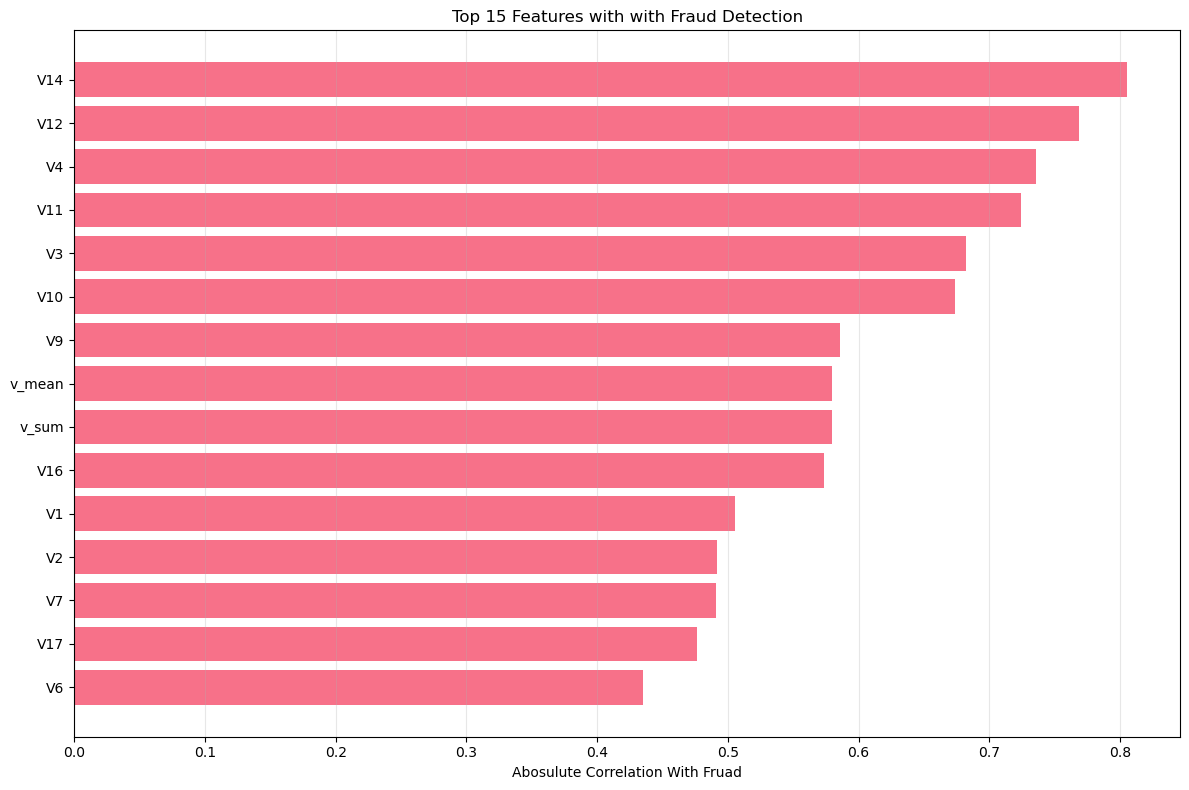

In [14]:
# ============================================================================
# 5. FEATURE IMPORTANCE ANALYSIS
# ============================================================================
print("\n5. Feature Importance Analysis...")

# Create visuals
top_features = [item[0] for item in sorted_correlations[:15]]
top_correlations = [builtins.abs(item[1]) for item in sorted_correlations[:15]]

plt.figure(figsize=(12,8))
plt.barh(range(len(top_features)), top_correlations)
plt.yticks(range(len(top_features)), top_features)
plt.xlabel("Abosulute Correlation With Fruad")
plt.title("Top 15 Features with with Fraud Detection")
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


6. Analyzing New Feature Distributions...


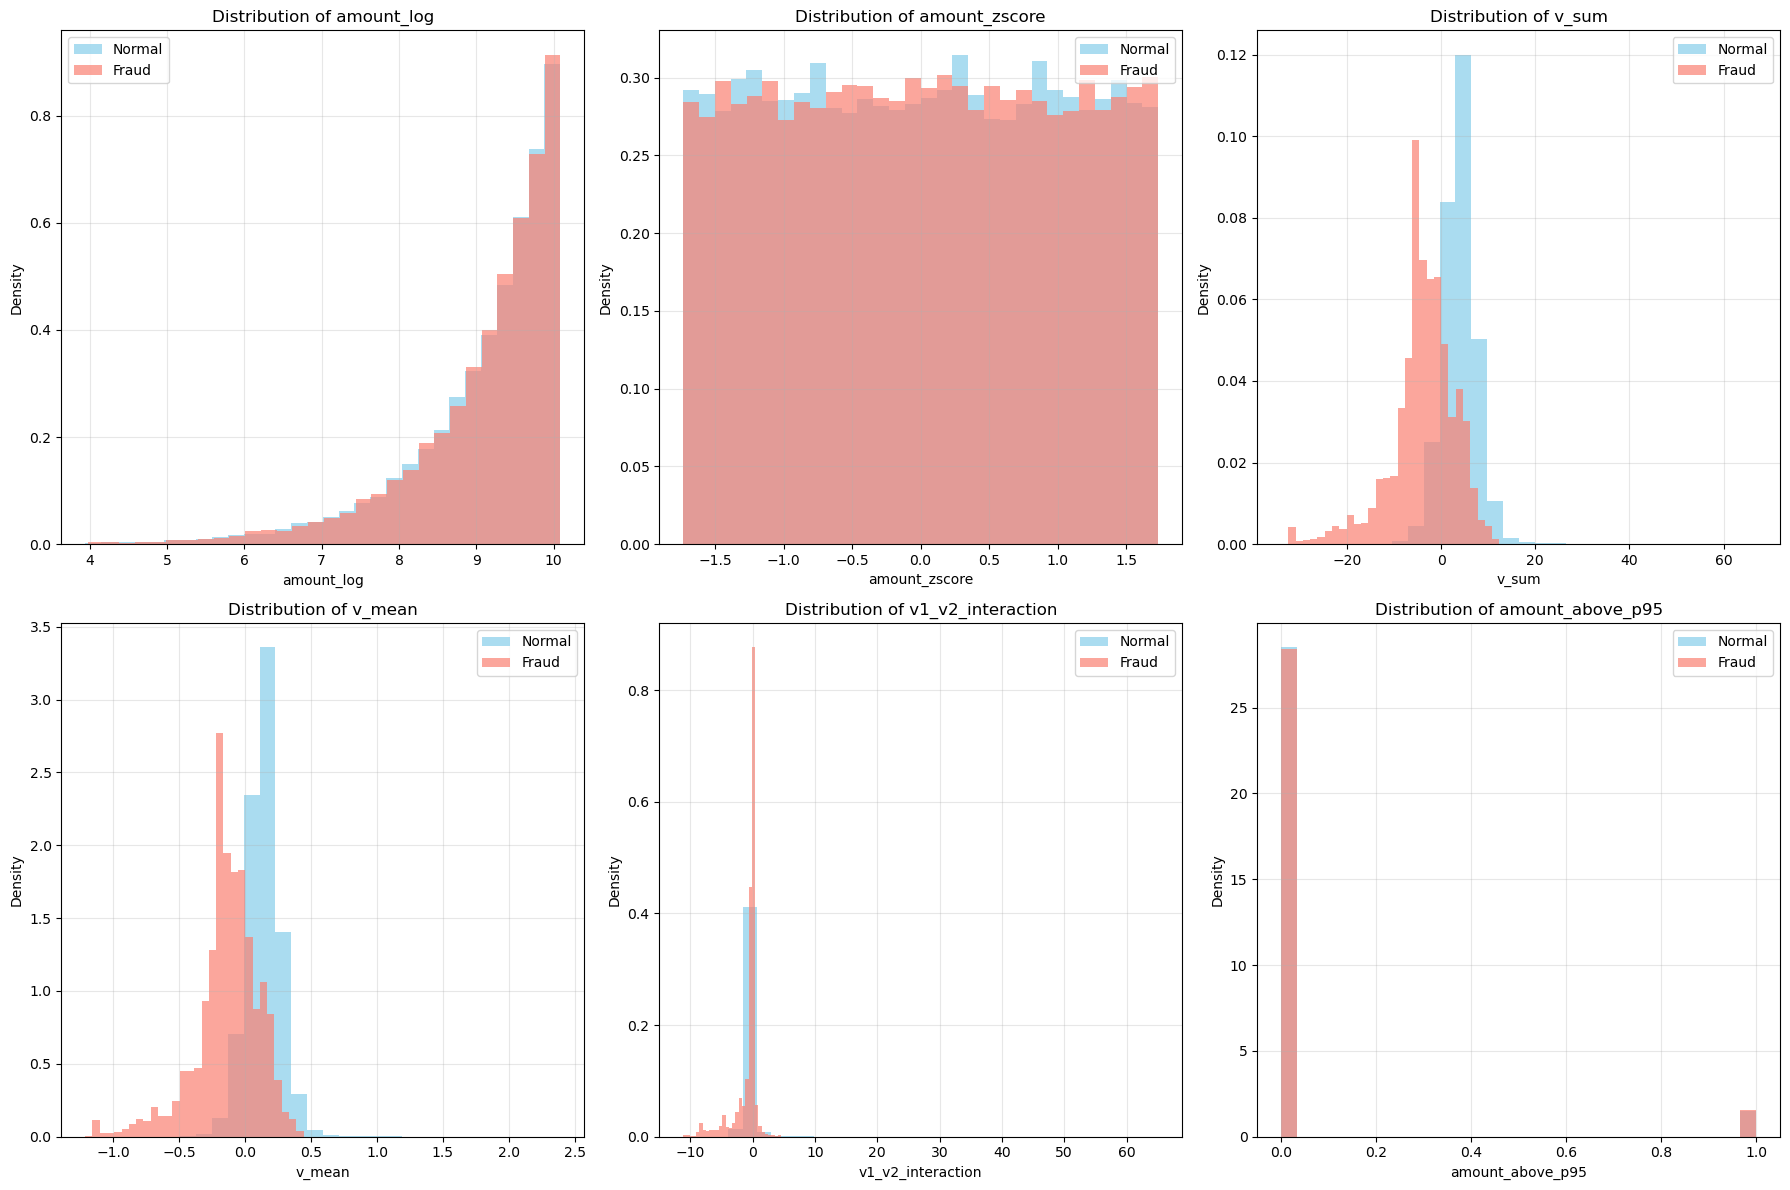

In [17]:
# ============================================================================
# 6. FEATURE DISTRIBUTION ANALYSIS
# ============================================================================
print("\n6. Analyzing New Feature Distributions...")

# Convert sample to pandas for detailed analysis
sample_df = df_features.sample(fraction=0.1, seed=42).toPandas()

# Analyze new features by class
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

key_new_features = ["amount_log", "amount_zscore", "v_sum", "v_mean", 
                   "v1_v2_interaction", "amount_above_p95"]

for i, feature in enumerate(key_new_features):
    ax = axes[i]
    
    normal_data = sample_df[sample_df['Class'] == 0][feature]
    fraud_data = sample_df[sample_df['Class'] == 1][feature]
    
    ax.hist(normal_data, bins=30, alpha=0.7, label='Normal', color='skyblue', density=True)
    ax.hist(fraud_data, bins=30, alpha=0.7, label='Fraud', color='salmon', density=True)
    
    ax.set_xlabel(feature)
    ax.set_ylabel('Density')
    ax.set_title(f'Distribution of {feature}')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [18]:
# 7. OUTLIER ANALYSIS
# ============================================================================
print("\n7. Outlier Analysis...")

# Analyze outlier patterns
outlier_analysis = df_features.groupBy("Class") \
    .agg(
        count("*").alias("total_transactions"),
        sum("amount_outlier").alias("amount_outliers"),
        sum("amount_above_p95").alias("high_amount_transactions"),
        avg("amount_zscore").alias("avg_zscore"),
        stddev("amount_zscore").alias("std_zscore")
    )

print("Outlier Analysis by Class:")
outlier_analysis.show()

# Calculate outlier rates
outlier_rates = outlier_analysis.toPandas()
outlier_rates['outlier_rate'] = outlier_rates['amount_outliers'] / outlier_rates['total_transactions'] * 100
outlier_rates['high_amount_rate'] = outlier_rates['high_amount_transactions'] / outlier_rates['total_transactions'] * 100

print("Outlier Rates:")
print(outlier_rates[['Class', 'outlier_rate', 'high_amount_rate']])


7. Outlier Analysis...
Outlier Analysis by Class:


+-----+------------------+---------------+------------------------+--------------------+------------------+
|Class|total_transactions|amount_outliers|high_amount_transactions|          avg_zscore|        std_zscore|
+-----+------------------+---------------+------------------------+--------------------+------------------+
|    1|            284315|              0|                   14149|0.002260828413600...|0.9985702216122322|
|    0|            284315|              0|                   14320|-0.00226082841358...| 1.001424389068433|
+-----+------------------+---------------+------------------------+--------------------+------------------+

Outlier Rates:
   Class  outlier_rate  high_amount_rate
0      1           0.0          4.976523
1      0           0.0          5.036667


In [19]:
# ============================================================================
# 8. FEATURE SCALING AND NORMALIZATION
# ============================================================================
print("\n8. Feature Scaling with Spark ML...")

# Prepare features for scaling
numeric_features = feature_columns
assembler_scale = VectorAssembler(inputCols=numeric_features, outputCol="unscaled_features")
scaler = StandardScaler(inputCol="unscaled_features", outputCol="scaled_features", 
                       withStd=True, withMean=True)

# Create pipeline for scaling
pipeline = Pipeline(stages=[assembler_scale, scaler])
pipeline_model = pipeline.fit(df_features)
df_scaled = pipeline_model.transform(df_features)

print("Features scaled successfully using StandardScaler")
print(f"Scaled feature vector dimension: {len(numeric_features)}")


8. Feature Scaling with Spark ML...


Features scaled successfully using StandardScaler
Scaled feature vector dimension: 40


In [20]:
# ============================================================================
# 9. SAVE PROCESSED DATA
# ============================================================================
print("\n9. Saving Processed Data...")

# Select final feature set
final_features = ["id", "Class"] + v_columns + ["Amount"] + new_features
df_final = df_features.select(final_features)

# Save as parquet for efficient storage
df_final.write.mode("overwrite").parquet("processed_data/features_engineered.parquet")

# Also save scaled features for modeling
df_scaled.select("id", "Class", "scaled_features").write.mode("overwrite").parquet("processed_data/features_scaled.parquet")

print("Data saved successfully:")
print("  • features_engineered.parquet: Raw engineered features")
print("  • features_scaled.parquet: Scaled features for modeling")



9. Saving Processed Data...


Data saved successfully:
  • features_engineered.parquet: Raw engineered features
  • features_scaled.parquet: Scaled features for modeling


In [21]:
# ============================================================================
# 10. FEATURE ENGINEERING SUMMARY
# ============================================================================
print("\n10. Feature Engineering Summary:")
print("=" * 60)

print(f"\n📊 Original Dataset:")
print(f"   • {df.count():,} transactions")
print(f"   • {len(df.columns)} original features")

print(f"\n🔧 Feature Engineering:")
print(f"   • {len(new_features)} new features created")
print(f"   • {len(final_features)} total features in final dataset")
print(f"   • Advanced statistical aggregations")
print(f"   • Outlier detection and flagging")
print(f"   • Feature interactions and combinations")

print(f"\n🎯 Key Insights:")
most_correlated = sorted_correlations[0]
print(f"   • Most fraud-correlated feature: {most_correlated[0]} ({most_correlated[1]:.4f})")
print(f"   • Outlier rate difference between classes identified")
print(f"   • Feature scaling applied for model readiness")

print(f"\n📁 Next Steps:")
print(f"   • Features ready for model development")
print(f"   • Data saved in optimized parquet format")
print(f"   • Scaled features prepared for ML algorithms")

print(f"\n✅ Day 2 Complete! Ready for Day 3: Model Development")

# Clean up
try:
    spark.stop()
    print("✅ Spark session closed successfully")
except Exception:
    print("⚠️ Spark session already closed")


10. Feature Engineering Summary:

📊 Original Dataset:
   • 568,630 transactions
   • 31 original features

🔧 Feature Engineering:
   • 12 new features created
   • 43 total features in final dataset
   • Advanced statistical aggregations
   • Outlier detection and flagging
   • Feature interactions and combinations

🎯 Key Insights:
   • Most fraud-correlated feature: V14 (-0.8057)
   • Outlier rate difference between classes identified
   • Feature scaling applied for model readiness

📁 Next Steps:
   • Features ready for model development
   • Data saved in optimized parquet format
   • Scaled features prepared for ML algorithms

✅ Day 2 Complete! Ready for Day 3: Model Development
✅ Spark session closed successfully
